In [11]:
# IMPORTS

import tensorflow as tf
import os
import pathlib
import time
import datetime
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from google.cloud import storage

In [1]:
photo_path_1 = os.path.join(os.getcwd(),"..","raw_data","photo","photo1")
sketch_path_1 = os.path.join(os.getcwd(),"..","raw_data","sketch","sketch1")

#Create two lists of the filenames in the corresponding paths and sort them
photo_list_1 = os.listdir(photo_path_1)
photo_list_1.sort()

sketch_list_1 = os.listdir(sketch_path_1)
sketch_list_1.sort()

NameError: name 'os' is not defined

In [24]:
sketch_path = "/Users/alicepannequin/code/dcorballorenzo/FF2S/sketch_preproc/sketch1_preproc/"

#Get the list of files in the path and sort it 
sketch_list = os.listdir(sketch_path)
sketch_list.sort()
sketch_list

['sketch0001.jpg',
 'sketch0002.jpg',
 'sketch0003.jpg',
 'sketch0004.jpg',
 'sketch0005.jpg',
 'sketch0006.jpg',
 'sketch0007.jpg',
 'sketch0008.jpg',
 'sketch0009.jpg',
 'sketch0010.jpg',
 'sketch0011.jpg',
 'sketch0012.jpg',
 'sketch0013.jpg',
 'sketch0014.jpg',
 'sketch0015.jpg',
 'sketch0016.jpg',
 'sketch0017.jpg',
 'sketch0018.jpg',
 'sketch0019.jpg',
 'sketch0020.jpg',
 'sketch0021.jpg',
 'sketch0022.jpg',
 'sketch0023.jpg',
 'sketch0024.jpg',
 'sketch0025.jpg',
 'sketch0026.jpg',
 'sketch0027.jpg',
 'sketch0028.jpg',
 'sketch0029.jpg',
 'sketch0030.jpg',
 'sketch0031.jpg',
 'sketch0032.jpg',
 'sketch0033.jpg',
 'sketch0034.jpg',
 'sketch0035.jpg',
 'sketch0036.jpg',
 'sketch0037.jpg',
 'sketch0038.jpg',
 'sketch0039.jpg',
 'sketch0040.jpg',
 'sketch0041.jpg',
 'sketch0042.jpg',
 'sketch0043.jpg',
 'sketch0044.jpg',
 'sketch0045.jpg',
 'sketch0046.jpg',
 'sketch0047.jpg',
 'sketch0048.jpg',
 'sketch0049.jpg',
 'sketch0050.jpg',
 'sketch0051.jpg',
 'sketch0052.jpg',
 'sketch0053

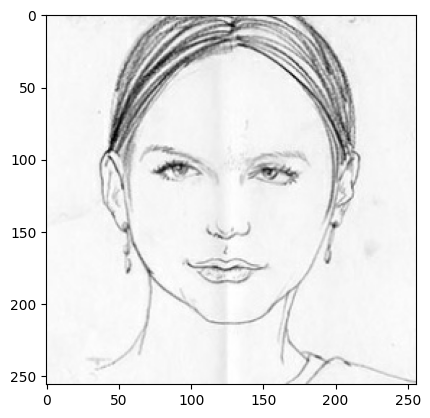

In [37]:
#ARTHUR

path = tf.data.Dataset.list_files('gs://ff2s/preproc_sketch/sketch*/*.jpg')

def load_image(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img)
    return img

ds_img = path.map(load_image)

plt.imshow(next(iter(ds_img.take(1))).numpy())

In [ ]:
# load the dataset
data = load('maps_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

GENERATOR

In [1]:
OUTPUT_CHANNELS = 3

In [12]:
#ENCODEUR

def downsample(filters, size, apply_batchnorm=True):
    
    init = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=init, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    return result

In [28]:
#DECODEUR

def upsample(filters, size, apply_dropout=False):
    
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [14]:
#GENERATEUR FINAL

def Generator():
    
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    init = tf.random_normal_initializer(0., 0.02)

    down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

    up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

    
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=init,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)
    



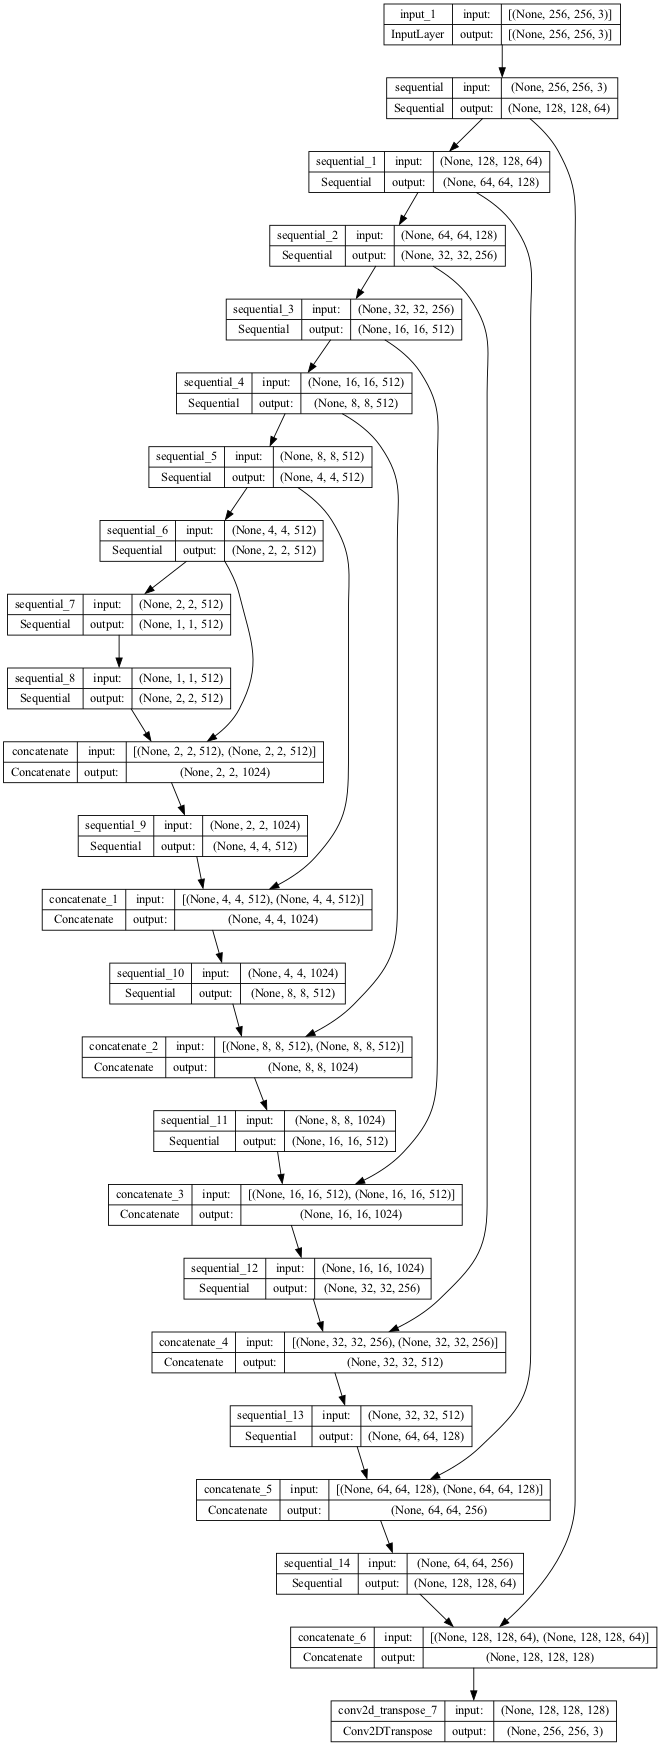

In [15]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [16]:
LAMBDA = 100

In [17]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

DISCRIMINATEUR

In [19]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')
  
  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)
  
  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  model = tf.keras.Model(inputs=[inp, tar], outputs=last) #define model 
  
  opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5)
  model.compile(loss='binary_crossentropy', optimizer= opt, loss_weights = [0.5])
  
  return model

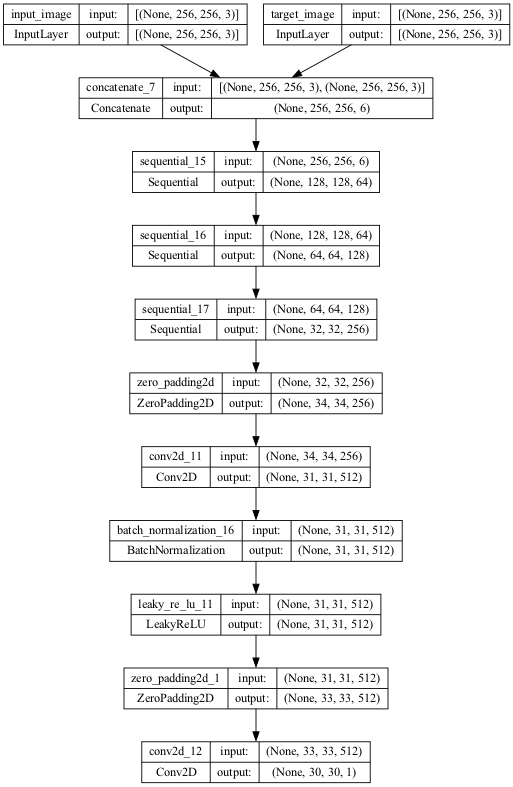

In [20]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [21]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

GAN FINAL

In [23]:
#GAN FINAL

# define the combined generator and discriminator model, for updating the generator
def define_gan(Generator, Discriminator, image_shape):
	# make weights in the discriminator not trainable
	for layer in Discriminator.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = Generator(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = Discriminator([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

TRAIN

In [38]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [24]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]